In [83]:
import warnings
warnings.filterwarnings('ignore')

from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler, normalize

from imblearn.over_sampling import SMOTE

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from json import JSONDecoder, JSONDecodeError  # for reading the JSON data files
import re  # for regular expressions
import os  # for os related operations
from collections import OrderedDict

import seaborn as sns
import lightgbm as lgb
from tqdm import tqdm_notebook as tqdm
import mlflow
import mlflow.sklearn
import time
import logging
from sklearn import svm
from sklearn.metrics import confusion_matrix

from sklearn.metrics import log_loss
from collections import Counter
import seaborn as sns

import hyperopt
from hyperopt import hp, tpe, fmin, Trials
from datetime  import datetime

from datetime import datetime
from sklearn.model_selection import train_test_split
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 199)

%run "../../src/data_preparation/utils.py"
%run "../../src/data_preparation/common_eda.py"
%run "../../src/visualization/common_visualization.py"
path_to_data = "../../data/raw/"

In [84]:
def lgb_f1_score(y_true, y_pred):
    y_pred = np.round(y_pred) # scikits f1 doesn't like probabilities
    return 'ff1', f1_score(y_true, y_pred), True

In [85]:
extra1 = pd.read_csv("../../data/processed/fold1.csv")
extra2 = pd.read_csv("../../data/processed/fold2.csv")
extra3 = pd.read_csv("../../data/processed/fold3.csv")
extra_submission = pd.read_csv("../../data/processed/fold_test.csv")

print(extra1.shape, extra2.shape, extra3.shape, extra_submission.shape)

(76773, 176) (92481, 176) (27006, 176) (173512, 176)


In [86]:
df1 = pd.read_csv("../../data/processed/fold1Training_60.csv")
df2 = pd.read_csv("../../data/processed/fold2Training_60.csv")
df3 = pd.read_csv("../../data/processed/fold3Training_60.csv")
df_submission = pd.read_csv("../../data/processed/testSet_60.csv")

print(df1.shape, df2.shape, df3.shape, df_submission.shape)

(76773, 1502) (92481, 1502) (27006, 1502) (173512, 1502)


In [87]:
c1 = Counter(df1.LABEL)
c2 = Counter(df2.LABEL)
c3 = Counter(df3.LABEL)

print("df1", df1.shape, c1, c1[1]*100/c1[0])
print("df2", df2.shape,c2, c2[1]*100/c2[0])
print("df3", df3.shape,c3, c3[1]*100/c3[0])

df1 (76773, 1502) Counter({0: 64222, 1: 12551}) 19.543147208121827
df2 (92481, 1502) Counter({0: 78516, 1: 13965}) 17.786183707779305
df3 (27006, 1502) Counter({0: 22236, 1: 4770}) 21.45169994603346


In [88]:
train = pd.merge(df1, extra1, on="ID", how="inner")
valid =  pd.merge(df2, extra2, on="ID", how="inner")
test = pd.merge(df3, extra3, on="ID", how="inner")
submission =  pd.merge(df_submission, extra_submission, on="ID", how="inner")

c_train = Counter(train.LABEL)
c_valid = Counter(valid.LABEL)
c_test = Counter(test.LABEL)
print("c_train", train.shape, c_train, c_train[1]*100/c_train[0])
print("c_valid", valid.shape, c_valid, c_valid[1]*100/c_valid[0])
print("c_test", test.shape, c_test, c_test[1]*100/c_test[0])
print("submission.shape = ", submission.shape)

c_train (76773, 1677) Counter({0: 64222, 1: 12551}) 19.543147208121827
c_valid (92481, 1677) Counter({0: 78516, 1: 13965}) 17.786183707779305
c_test (27006, 1677) Counter({0: 22236, 1: 4770}) 21.45169994603346
submission.shape =  (173512, 1677)


In [89]:
total_cols =  list(train.iloc[:, :-2].columns.values) 

In [90]:
ori = ['TOTUSJH', 'TOTBSQ', 'TOTPOT', 'TOTUSJZ', 'ABSNJZH', 'SAVNCPP', 'USFLUX', 'TOTFZ', 'MEANPOT', 'EPSZ', 'MEANSHR', 'SHRGT45', 'MEANGAM', 'MEANGBT', 'MEANGBZ', 'MEANGBH', 'MEANJZH', 'TOTFY', 'MEANJZD', 'MEANALP', 'TOTFX', 'EPSY', 'EPSX', 'R_VALUE', 'XR_MAX']
ori_cols = [c + "_59" for c in ori] #+ [c + "_58" for c in ori]

selected_cols_1 = [c for c in total_cols if 'TOTU' in c] 
selected_cols_2 = []   #[c for c in total_cols if 'ABSNJZH' in c] 
selected_cols_3 = []   #[c for c in total_cols if 'USFLUX' in c] 
selected_cols_4 = []   #[c for c in total_cols if 'SAVNCPP' in c] 


extra_cols = list(extra1.drop("ID",1).columns)
feature_cols = ori_cols + selected_cols_1 + selected_cols_2 + selected_cols_3 + selected_cols_4 + extra_cols
feature_cols = list(set(feature_cols))

## Normalization

In [91]:
# df = train.copy()
# cols = list(df.columns)[:-175]
# df[cols]
# for col in cols:
#     col_zscore = col + '_zscore'
#     df[col_zscore] = (df[col] - df[col].mean())/df[col].std()

In [92]:
# train = train.apply(zscore)
# valid = valid.apply(lambda x: x if np.std(x) == 0 else zscore(x))
# test = test.apply(lambda x: x if np.std(x) == 0 else zscore(x))
# submission = submission.apply(lambda x: x if np.std(x) == 0 else zscore(x))

In [93]:
 train.head()

,TOTUSJH_0,TOTBSQ_0,TOTPOT_0,TOTUSJZ_0,ABSNJZH_0,SAVNCPP_0,USFLUX_0,TOTFZ_0,MEANPOT_0,EPSZ_0,MEANSHR_0,SHRGT45_0,MEANGAM_0,MEANGBT_0,MEANGBZ_0,MEANGBH_0,MEANJZH_0,TOTFY_0,MEANJZD_0,MEANALP_0,TOTFX_0,EPSY_0,EPSX_0,R_VALUE_0,XR_MAX_0,TOTUSJH_1,TOTBSQ_1,TOTPOT_1,TOTUSJZ_1,ABSNJZH_1,SAVNCPP_1,USFLUX_1,TOTFZ_1,MEANPOT_1,EPSZ_1,MEANSHR_1,SHRGT45_1,MEANGAM_1,MEANGBT_1,MEANGBZ_1,MEANGBH_1,MEANJZH_1,TOTFY_1,MEANJZD_1,MEANALP_1,TOTFX_1,EPSY_1,EPSX_1,R_VALUE_1,XR_MAX_1,TOTUSJH_2,TOTBSQ_2,TOTPOT_2,TOTUSJZ_2,ABSNJZH_2,SAVNCPP_2,USFLUX_2,TOTFZ_2,MEANPOT_2,EPSZ_2,MEANSHR_2,SHRGT45_2,MEANGAM_2,MEANGBT_2,MEANGBZ_2,MEANGBH_2,MEANJZH_2,TOTFY_2,MEANJZD_2,MEANALP_2,TOTFX_2,EPSY_2,EPSX_2,R_VALUE_2,XR_MAX_2,TOTUSJH_3,TOTBSQ_3,TOTPOT_3,TOTUSJZ_3,ABSNJZH_3,SAVNCPP_3,USFLUX_3,TOTFZ_3,MEANPOT_3,EPSZ_3,MEANSHR_3,SHRGT45_3,MEANGAM_3,MEANGBT_3,MEANGBZ_3,MEANGBH_3,MEANJZH_3,TOTFY_3,MEANJZD_3,MEANALP_3,TOTFX_3,EPSY_3,EPSX_3,R_VALUE_3,XR_MAX_3,TOTUSJH_4,TOTBSQ_4,TOTPOT_4,TOTUSJZ_4,ABSNJZH_4,SAVNCPP_4,USFLUX_4,TOTFZ_4,MEANPOT_4,EPSZ_4,MEANSHR_4,SHRGT45_4,MEANGAM_4,MEANGBT_4,MEANGBZ_4,MEANGBH_4,MEANJZH_4,TOTFY_4,MEANJZD_4,MEANALP_4,TOTFX_4,EPSY_4,EPSX_4,R_VALUE_4,XR_MAX_4,TOTUSJH_5,TOTBSQ_5,TOTPOT_5,TOTUSJZ_5,ABSNJZH_5,SAVNCPP_5,USFLUX_5,TOTFZ_5,MEANPOT_5,EPSZ_5,MEANSHR_5,SHRGT45_5,MEANGAM_5,MEANGBT_5,MEANGBZ_5,MEANGBH_5,MEANJZH_5,TOTFY_5,MEANJZD_5,MEANALP_5,TOTFX_5,EPSY_5,EPSX_5,R_VALUE_5,XR_MAX_5,TOTUSJH_6,TOTBSQ_6,TOTPOT_6,TOTUSJZ_6,ABSNJZH_6,SAVNCPP_6,USFLUX_6,TOTFZ_6,MEANPOT_6,EPSZ_6,MEANSHR_6,SHRGT45_6,MEANGAM_6,MEANGBT_6,MEANGBZ_6,MEANGBH_6,MEANJZH_6,TOTFY_6,MEANJZD_6,MEANALP_6,TOTFX_6,EPSY_6,EPSX_6,R_VALUE_6,XR_MAX_6,TOTUSJH_7,TOTBSQ_7,TOTPOT_7,TOTUSJZ_7,ABSNJZH_7,SAVNCPP_7,USFLUX_7,TOTFZ_7,MEANPOT_7,EPSZ_7,MEANSHR_7,SHRGT45_7,MEANGAM_7,MEANGBT_7,MEANGBZ_7,MEANGBH_7,MEANJZH_7,TOTFY_7,MEANJZD_7,MEANALP_7,TOTFX_7,EPSY_7,EPSX_7,R_VALUE_7,XR_MAX_7,TOTUSJH_8,TOTBSQ_8,TOTPOT_8,TOTUSJZ_8,ABSNJZH_8,SAVNCPP_8,USFLUX_8,TOTFZ_8,MEANPOT_8,EPSZ_8,MEANSHR_8,SHRGT45_8,MEANGAM_8,MEANGBT_8,MEANGBZ_8,MEANGBH_8,MEANJZH_8,TOTFY_8,MEANJZD_8,MEANALP_8,TOTFX_8,EPSY_8,EPSX_8,R_VALUE_8,XR_MAX_8,TOTUSJH_9,TOTBSQ_9,TOTPOT_9,TOTUSJZ_9,ABSNJZH_9,SAVNCPP_9,USFLUX_9,TOTFZ_9,MEANPOT_9,EPSZ_9,MEANSHR_9,SHRGT45_9,MEANGAM_9,MEANGBT_9,MEANGBZ_9,MEANGBH_9,MEANJZH_9,TOTFY_9,MEANJZD_9,MEANALP_9,TOTFX_9,EPSY_9,EPSX_9,R_VALUE_9,XR_MAX_9,...,TOTPOT_57,TOTUSJZ_57,ABSNJZH_57,SAVNCPP_57,USFLUX_57,TOTFZ_57,MEANPOT_57,EPSZ_57,MEANSHR_57,SHRGT45_57,MEANGAM_57,MEANGBT_57,MEANGBZ_57,MEANGBH_57,MEANJZH_57,TOTFY_57,MEANJZD_57,MEANALP_57,TOTFX_57,EPSY_57,EPSX_57,R_VALUE_57,XR_MAX_57,TOTUSJH_58,TOTBSQ_58,TOTPOT_58,TOTUSJZ_58,ABSNJZH_58,SAVNCPP_58,USFLUX_58,TOTFZ_58,MEANPOT_58,EPSZ_58,MEANSHR_58,SHRGT45_58,MEANGAM_58,MEANGBT_58,MEANGBZ_58,MEANGBH_58,MEANJZH_58,TOTFY_58,MEANJZD_58,MEANALP_58,TOTFX_58,EPSY_58,EPSX_58,R_VALUE_58,XR_MAX_58,TOTUSJH_59,TOTBSQ_59,TOTPOT_59,TOTUSJZ_59,ABSNJZH_59,SAVNCPP_59,USFLUX_59,TOTFZ_59,MEANPOT_59,EPSZ_59,MEANSHR_59,SHRGT45_59,MEANGAM_59,MEANGBT_59,MEANGBZ_59,MEANGBH_59,MEANJZH_59,TOTFY_59,MEANJZD_59,MEANALP_59,TOTFX_59,EPSY_59,EPSX_59,R_VALUE_59,XR_MAX_59,LABEL,ID,SUM(data.TOTUSJH),SUM(data.TOTBSQ),SUM(data.TOTPOT),SUM(data.TOTUSJZ),SUM(data.ABSNJZH),SUM(data.SAVNCPP),SUM(data.USFLUX),SUM(data.TOTFZ),SUM(data.MEANPOT),SUM(data.EPSZ),SUM(data.MEANSHR),SUM(data.SHRGT45),SUM(data.MEANGAM),SUM(data.MEANGBT),SUM(data.MEANGBZ),SUM(data.MEANGBH),SUM(data.MEANJZH),SUM(data.TOTFY),SUM(data.MEANJZD),SUM(data.MEANALP),SUM(data.TOTFX),SUM(data.EPSY),SUM(data.EPSX),SUM(data.R_VALUE),SUM(data.XR_MAX),MAX(data.TOTUSJH),MAX(data.TOTBSQ),MAX(data.TOTPOT),MAX(data.TOTUSJZ),MAX(data.ABSNJZH),MAX(data.SAVNCPP),MAX(data.USFLUX),MAX(data.TOTFZ),MAX(data.MEANPOT),MAX(data.EPSZ),MAX(data.MEANSHR),MAX(data.SHRGT45),MAX(data.MEANGAM),MAX(data.MEANGBT),MAX(data.MEANGBZ),MAX(data.MEANGBH),MAX(data.MEANJZH),MAX(data.TOTFY),MAX(data.MEANJZD),MAX(data.MEANALP),MAX(data.TOTFX),MAX(data.EPSY),MAX(data.EPSX),MAX(data.R_VALUE),MAX(data.XR_MAX),MIN(data.TOTUSJH),MIN(data.TOTBSQ),MIN(data.TOTPOT),MIN(data.TOTUSJ

In [94]:
def norm_data(df, feature_cols):
    scaler = MinMaxScaler(feature_range=(-1,1))

    for c in feature_cols:
        null_values = df[c].isnull()
        df.loc[~null_values, [c]] = scaler.fit_transform(df.loc[~null_values, [c]])
    return df


train["type"] = "fold1"
valid["type"] = "fold2"
test["type"] = "fold3"
submission["type"] = "fold_sub"

all_folds = pd.concat([train, valid, test, submission])
all_folds = norm_data(all_folds, feature_cols)
all_folds.shape

(369772, 1678)

In [95]:
train = all_folds[all_folds.type == "fold1"]
valid = all_folds[all_folds.type == "fold2"]
test = all_folds[all_folds.type == "fold3"]
submission = all_folds[all_folds.type == "fold_sub"]

## FINAL 

In [96]:
train_valid = pd.concat([train, valid]).reset_index(drop=True)

X_train, y_train  = train_valid[feature_cols].fillna(0), train_valid.LABEL
X_valid, y_valid  = test[feature_cols].fillna(0), test.LABEL
X_submission = submission[feature_cols].fillna(0)

In [97]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [98]:
model.fit(X_train, y_train)
train_pred_prob = model.predict_proba(X_train)[:,1]
valid_pred_prob = model.predict_proba(X_valid)[:,1]

In [99]:
model.coef_

array([[-3.38448564e-01, -4.94302995e-01,  2.28795515e+00,
         2.19457620e+00,  8.92412657e-01,  7.29158226e-01,
         3.54194976e-01, -8.35188586e-01,  2.75694499e+00,
        -3.31502696e-01,  7.48186026e-01, -1.76910115e-01,
        -1.38976746e+00, -1.07585651e-01, -2.19797244e-02,
         8.16145213e-01,  8.08621424e-01, -3.18571192e-01,
        -3.52659751e-01, -1.60673256e-01,  3.41212000e+00,
         2.48972371e+00, -6.76154777e-01, -5.62312463e-01,
        -2.12260436e-02,  1.64653117e-01,  4.42598185e-02,
         5.96319130e-01, -4.30136542e-02, -2.78619698e-01,
         1.06118438e+00,  2.42384830e-01, -7.52513743e-01,
        -1.51223374e+00,  1.32654847e+00,  3.75461581e-01,
         1.25409780e+00,  5.07070721e-01,  2.87355918e-01,
         3.76025913e-01, -8.11645488e-02, -5.15836279e+00,
        -1.63889455e+00, -1.63311024e-01, -1.14903393e+00,
         9.31505877e-02,  5.02748838e-01, -1.45756475e+00,
         6.45643469e-01,  9.00283035e-01, -1.25400055e-0

In [100]:
y_pred_sub_prob = model.predict_proba(X_submission)[:,1]
y_pred_sub_prob

array([0.03162336, 0.02575633, 0.00108069, ..., 0.00136316, 0.01432429,
       0.00011147])

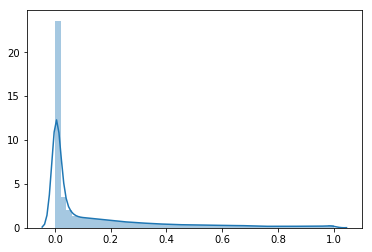

In [101]:
sns.distplot(train_pred_prob)

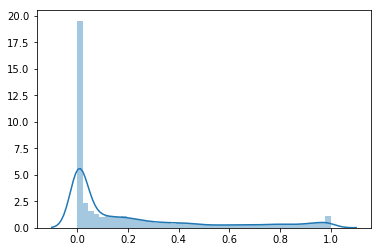

In [102]:
sns.distplot(valid_pred_prob)

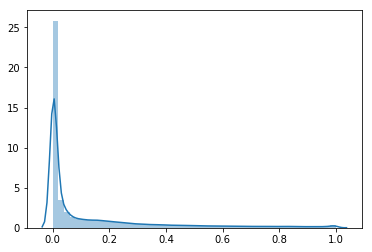

In [103]:
sns.distplot(y_pred_sub_prob)

In [114]:
train_pred = train_pred_prob > 0.32
c = Counter(train_pred)
print(c[1]*100/c[0])
print(f1_score(y_train, train_pred))

22.775049507823326
0.6593683628891613


In [128]:
valid_pred = valid_pred_prob > 0.5
c = Counter(valid_pred)
print(c[1]*100/c[0])
print(f1_score(y_valid, valid_pred))

21.56103709038531
0.694560669456067


In [146]:
y_pred_sub = y_pred_sub_prob > 0.28
c = Counter(y_pred_sub)
print(c[1]*100/c[0])

21.341305640057346


In [147]:
y_pred_sub

array([False, False, False, ..., False, False, False])

In [152]:
submission_df = pd.DataFrame({"Id": submission.ID, "ClassLabel": list(y_pred_sub)})
print(Counter(submission_df.ClassLabel))
submission_df.ClassLabel = submission_df.ClassLabel.astype(int)

submission_df.to_csv("../../data/output/ouput_{}.csv".format(str("be")), index=False)
submission_df.head(10)

# Counter({0: 141287, 1: 32225})


Counter({False: 142995, True: 30517})


,Id,ClassLabel
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
5,6,0
6,7,0
7,8,0
8,9,0
9,10,0


In [155]:
valid_df = pd.DataFrame(data={"pred_logistic": (valid_pred_prob), "label_logistic": y_valid})
valid_df.label_logistic = valid_df.label_logistic.astype(int)
valid_df.to_csv("../../data/intermediate/logistic_63246.csv", index=False)
print(valid_df.shape)
valid_df.head()

(27006, 2)


,pred_logistic,label_logistic
0,0.727910,1
1,0.046409,0
2,0.001951,0
3,0.031647,0
4,0.026562,0


In [156]:
submit_prob_df = pd.DataFrame(data={"pred_logistic": (y_pred_sub_prob), "label_logistic": [np.nan]*len(y_pred_sub_prob)})
submit_prob_df.to_csv("../../data/intermediate/logistic_63246_sub_thres0.28.csv", index=False)
submit_prob_df.shape

(173512, 2)

In [151]:
_713 = pd.read_csv("../../data/output/ouput_0.7133364529714553 (1).csv")
sum(_713.ClassLabel == submission_df.ClassLabel)/len(submission_df)

0.9404248697496427